In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [2]:
BUFFER_SIZE = 400
EPOCHS = 100
LAMBDA = 100
DATASET = 'cityscapes'
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256
patch_size = 8
num_patches = (IMG_HEIGHT // patch_size) ** 2
projection_dim = 64
embed_dim = 64
num_heads = 2 
ff_dim = 32

assert IMG_WIDTH == IMG_HEIGHT, "image width and image height must have same dims"


In [3]:
_URL = f'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/{DATASET}.tar.gz'

path_to_zip = tf.keras.utils.get_file(f'{DATASET}.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), f'{DATASET}/')

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

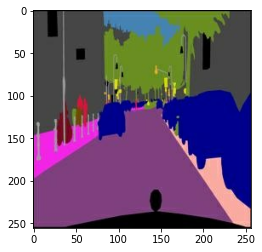

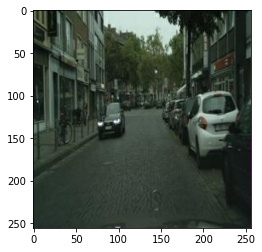

In [5]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [8]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return real_image, input_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

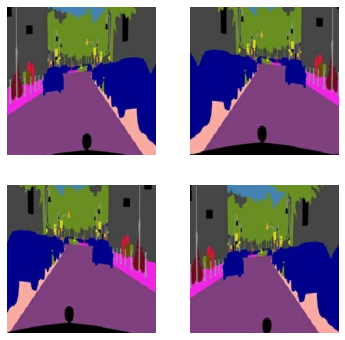

In [10]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [11]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [12]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [13]:
tf.config.run_functions_eagerly(False)

train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
try:
    test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
    test_dataset = test_dataset.map(load_image_test)
    test_dataset = test_dataset.batch(BATCH_SIZE)
except:
    test_dataset = train_dataset

In [15]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [16]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [17]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [18]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [19]:
from tensorflow.keras import layers

def Generator():

    inputs = layers.Input(shape=(256, 256, 3))

    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    x = TransformerBlock(64, num_heads, ff_dim)(encoded_patches)
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = TransformerBlock(64, num_heads, ff_dim)(x)
    x = TransformerBlock(64, num_heads, ff_dim)(x)

    x = layers.Reshape((8, 8, 1024))(x)

    x = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=512)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=256)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = residual_block(x, downsample=False, filters=64)

    x = layers.Conv2DTranspose(32, (5, 5), strides=(4, 4), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = residual_block(x, downsample=False, filters=32)

    x = layers.Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [20]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
patches (Patches)               (None, None, 192)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 1024, 64)     77888       patches[0][0]                    
__________________________________________________________________________________________________
transformer_block (TransformerB (None, 1024, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


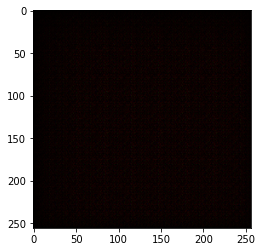

In [21]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

def generate_batch_images(model, test_input, tar):
    for i in range(len(test_input)):
      prediction = model(test_input, training=True)
      plt.figure(figsize=(15, 15))

      display_list = [test_input[i], tar[i], prediction[i]]
      title = ['Input Image', 'Ground Truth', 'Predicted Image']
      
      for i in range(3):
          plt.subplot(1, 3, i+1)
          plt.title(title[i])
          # getting the pixel values between [0, 1] to plot it.
          plt.imshow(display_list[i] * 0.5 + 0.5)
          plt.axis('off')
      plt.show()

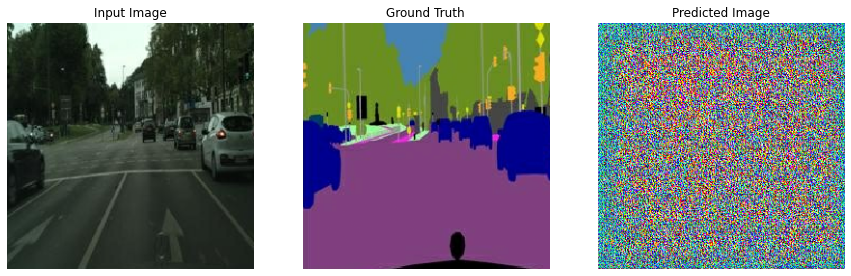

In [24]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [25]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = generator(input_image, training=True)

            gen_total_loss = tf.reduce_mean(tf.abs(target - gen_output))
            
        generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))

In [26]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    generator.save_weights(f'_{DATASET}-gen-weights.h5')
    discriminator.save_weights(f'_{DATASET}-disc-weights.h5')

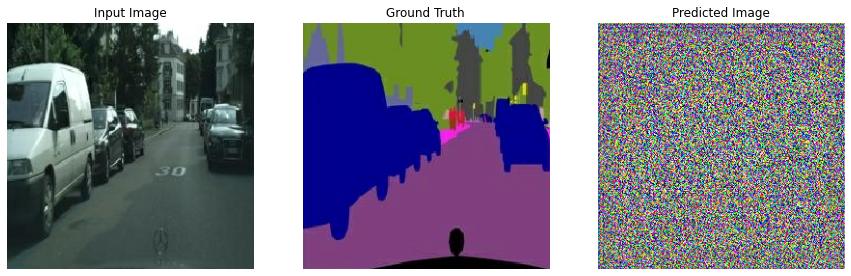

Epoch:  0
.

KeyboardInterrupt: 

In [34]:
fit(train_dataset, 100000, test_dataset)

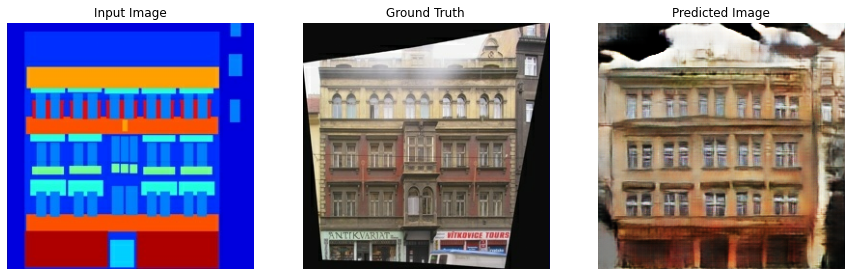

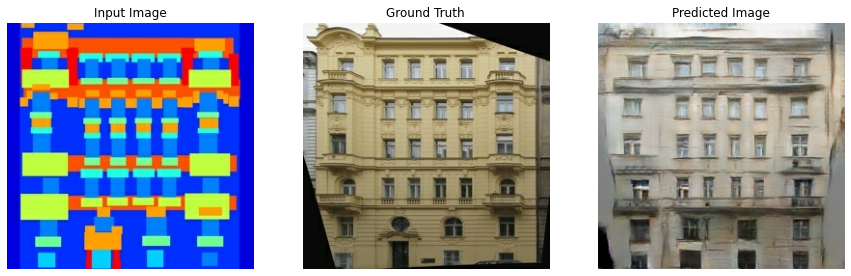

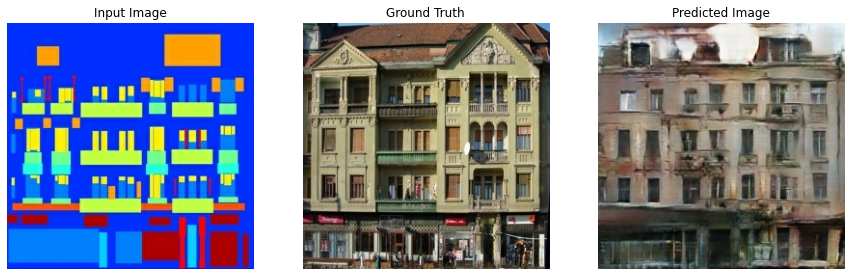

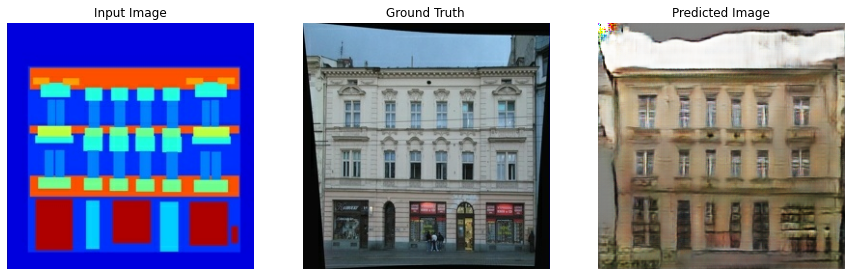

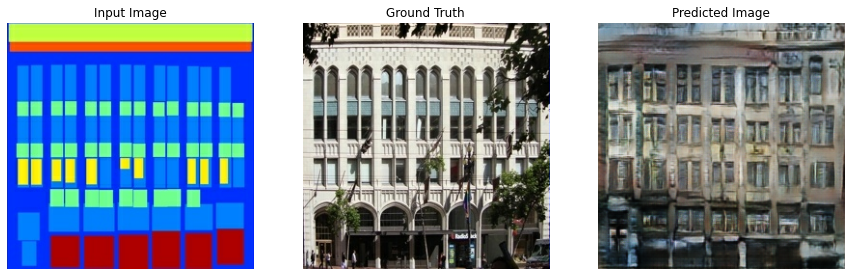

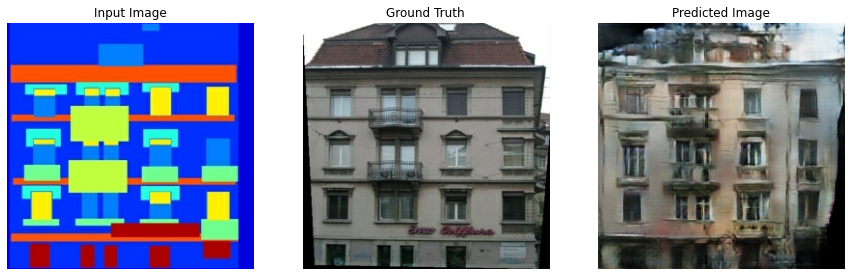

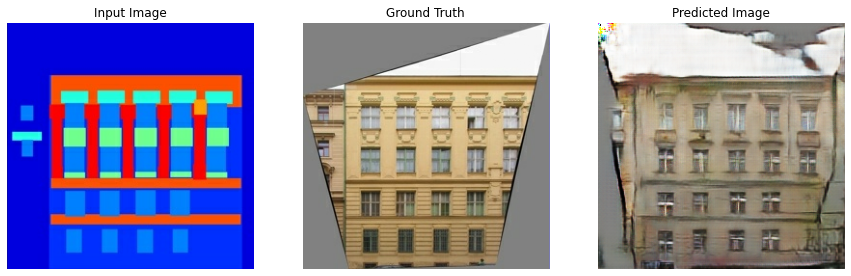

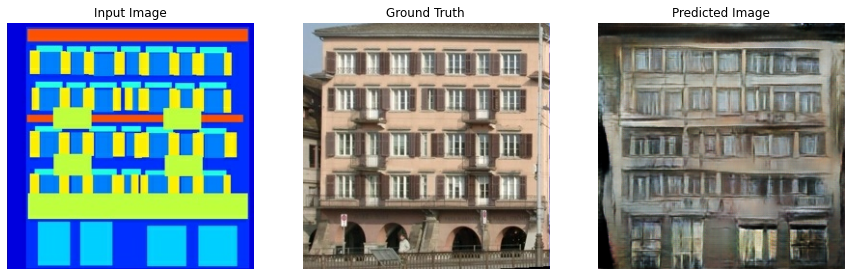

In [141]:
for inp, tar in test_dataset.take(1):
    outs = generator(inp)
    generate_batch_images(generator, inp, tar)